# Circular waveguide filter - Discussion

In [1]:
# Temporary 'hack' for working directory not coinciding with file directory
import os
os.chdir('/home/fenics/shared/examples/circular_waveguide_filter')

%load_ext autoreload
%autoreload 2

In [2]:
import time
import numpy as np
import matplotlib.pyplot as plt

import fenics as fen
from circular_waveguide_filter import CircularWaveguideFilter

from context import src
from src.vector_space import VectorSpaceL2
from src.minimal_rational_interpolation import MinimalRationalInterpolation
import src.helpers as helpers

### Dimensions and properties

In [3]:
# Dimensions in meters
Lc = 0.04387  # Length of the cavities
Ls = 0.00150  # Length of the slots
Lr = 0.02000  # Length of rectangular input/output WR75-waveguide
Hr = 0.009525 # Height of rectangular input/output WR75-waveguide
Wr = 0.01905  # Width of rectangular input/output WR75-waveguide

Dx = Ls/2 + Lc + Ls + Lr  # |x|-coordinate of input/output boundary
Dy = Wr/2  # |y|-limit of input/output boundary
Dz = Hr/2  # |z|-limit of input/output boundary

In [4]:
class B_N(fen.SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and fen.near(abs(x[0]), Dx) and x[1]>-Dy and x[1]<Dy and x[2]>-Dz and x[2]<Dz

class g_N_L(fen.UserExpression):
    def eval(self, value, x):
        value[0] = 0.0
        value[1] = 0.0
        value[2] = 1.0 / (4e-7*np.pi) if fen.near(x[0], -Dx) else 0.0
    def value_shape(self):
        return (3,)

class g_N_R(fen.UserExpression):
    def eval(self, value, x):
        value[0] = 0.0
        value[1] = 0.0
        value[2] = - 1.0 / (4e-7*np.pi) if fen.near(x[0], -Dx) else 0.0
    def value_shape(self):
        return (3,)

mesh = os.getcwd() + '/model/DMCWF.xml'
CWF = CircularWaveguideFilter(mesh, B_N, g_N=g_N_L())
VS = VectorSpaceL2(CWF)
CWF.setup()

### Solution of problem

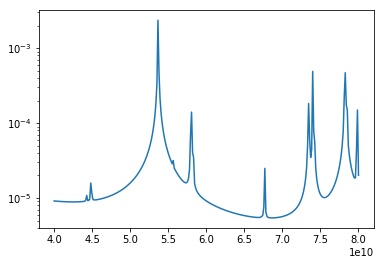

In [5]:
a = 4e+10
b = 8e+10
fig, ax = plt.subplots(figsize=(6, 4), sharex=True)
omegas = np.linspace(a, b, 300)
#CWF.solve(omegas)
#CWF.save_solution('snapshots/linspace_4e10_8e10_300.obj')
CWF.load_solution( 'snapshots/linspace_4e10_8e10_300.obj')
helpers.plot_solution_norms(ax, CWF, VS)

In [23]:
#CWF.save_solution('snapshots/linspace_4e10_8e10_50.obj')

In [10]:
class trace(fen.SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and fen.near(x[0], Dx) and x[1]>-Dy and x[1]<Dy and x[2]>-Dz and x[2]<Dz

VS = VectorSpaceL2(CWF, trace())
fig, ax = plt.subplots(figsize=(6, 4), sharex=True)
helpers.plot_solution_norms(ax, CWF, VS)

In [25]:
#CWF.save_solution('snapshots/linspace_4e10_8e10_50_trace.obj', trace=trace())

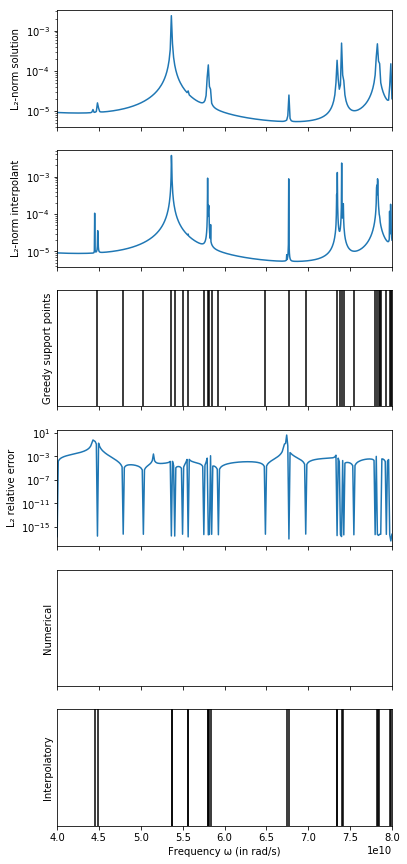

In [9]:
fig, ax = plt.subplots(6, 1, figsize=(6, 15), sharex=True)

a = 4e+10
b = 8e+10
VS = VectorSpaceL2(CWF)
MRI = MinimalRationalInterpolation(VS)
snapshots = CWF.get_solution(tonumpy=True, trace=VS.get_trace())
omegas = CWF.get_frequency()
MRI.compute_surrogate(snapshots, omegas, greedy=True, tol=1e-1)

ax[0].set_ylabel('L\u2082-norm solution')
helpers.plot_solution_norms(ax[0], CWF, VS)

ax[1].set_ylabel('L\u2082-norm interpolant')
helpers.plot_surrogate_norms(ax[1], MRI, a, b)

ax[2].set_ylabel('Greedy support points')
helpers.plot_lines(ax[2], MRI.A_ring.get_nodes())

ax[3].set_ylabel('L\u2082 relative error')
helpers.plot_surrogate_error_norms(ax[3], CWF, MRI, VS)

eigfreqs, eigvecs = CWF.get_numerical_eigenfrequencies(a, b, return_eigvecs=True)

ax[4].set_ylabel('Numerical')
helpers.plot_lines(ax[4], eigfreqs)

ax[5].set_ylabel('Inte rpolatory')
helpers.plot_lines(ax[5], MRI.get_interpolatory_eigenfrequencies(only_real=True))

ax[-1].set_xlabel('Frequency \u03C9 (in rad/s)')
ax[-1].set_xlim(a, b)
plt.show()

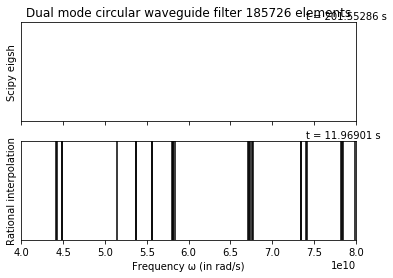

In [7]:
VS = VectorSpaceL2(CWF)
snapshots = CWF.get_solution(tonumpy=True, trace=VS.get_trace())
fig, ax = plt.subplots(2, 1, figsize=(6, 4), sharex=True)
#helpers.plot_lines(ax[0], CWF.get_analytical_eigenfrequencies(a, b), color='C0')
t0 = time.time()
helpers.plot_lines(ax[0], CWF.get_numerical_eigenfrequencies(a, b))
t_FE = time.time() - t0
#helpers.plot_lines(ax[1], CWF.get_analytical_eigenfrequencies(a, b), color='C0')
t0 = time.time()
MRI = MinimalRationalInterpolation(VS)
MRI.compute_surrogate(snapshots, omegas, greedy=True, tol=1e-2)
helpers.plot_lines(ax[1], MRI.get_interpolatory_eigenfrequencies(only_real=True))
t_RI = time.time() - t0
ax[0].set_title(f'Circular waveguide filter with {CWF.V.dim()} elements')
ax[0].set_ylabel('Scipy eigsh')
ax[0].text(0.85, 1.03, f't = {round(t_FE, 5)} s', transform=ax[0].transAxes)
ax[0].set_yticks([])
ax[1].set_ylabel('Rational interpolation')
ax[0].text(0.85, 1.03, f't = {round(t_RI, 5)} s', transform=ax[1].transAxes)
ax[1].set_yticks([])
ax[1].set_xlabel('Frequency \u03C9 (in rad/s)')
ax[1].set_xlim(a, b)
plt.show()